# Harmonic Motion
In this workshop we implement several solvers that integrate the equation of motion of a pendulum.
We consider both a linear pendulum, with friction and driving, and a non-linear pendulum.


In [1]:
# Import some libraries from python and set some defaults
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.image as mpimg
import sys
import os
import time
sys.path.append(os.getcwd())
# from scipy.interpolate import CubicSpline
import pickle
import copy
#set the font size for plots
plt.rcParams.update({'font.size': 17})
params = {'axes.labelsize': 16, 'axes.titlesize': 16}
plt.rcParams.update(params)
rc('animation', html='html5')

In [2]:
import requests
from pathlib import Path

# get the `DEq_solver.py` file
if Path("DEq_Solver.py").is_file():
    print("DEq_Solver already exist")
else:
    print("Downloading the DEq_Solver")
    request = requests.get("https://raw.githubusercontent.com/keithonpy/Scientific_Computing/main/Base/DEq_Solver.py")
    with open('DEq_Solver.py', 'wb') as f:
        f.write(request.content)

# get the `solver.py` file
if Path("solvers.py").is_file():
    print("solver already exist")
else:
    print("Downloading the solvers")
    request = requests.get("https://raw.githubusercontent.com/keithonpy/Scientific_Computing/main/Base/solvers.py")
    with open('solvers.py', 'wb') as f:
        f.write(request.content)
print("DEq_Solver and solvers imported")
        
        
from DEq_Solver import DEq_Solver
# import the solvers from the previous sessions
from DEq_Solver import DEq_Solver
from solvers import RK2Solver
from solvers import RK4Solver
from solvers import EulerSolver
import solvers

DEq_Solver and solvers imported


## Simple harmonic motion

Simple harmonic motion is of the form

$$
\theta(t) = A\,\cos(\omega t+\phi)\,,
$$

where the amplitude, $A$, the angular frequency, $\omega$, and the phase-angle, $\phi$ are all constants.
In the case of a pendulum, $A$ is an angle. For **simple harmonic motion**, we assume that the extent $|\theta|$ is always small, $|\theta|\ll 1$, so that we can make the small angle approximation, $\theta\approx\sin(\theta)$.

In this assignment, we will initialize the pendulum by specifying $\theta_0=\theta(t=0)$ and letting the pendulum go without giving it an initial velocity.

The derivative of $\theta(t)$ is

$$
\dot\theta(t) = -\omega\,A\,\sin(\omega t + \phi)\,.
$$

If the initial velocity is $\dot\theta=0$, this means that $\phi=0$, and therefore $A=\theta_0$. 

The phase-angle $\phi$ is, as any angle, determined up to $2\pi$ when expressed in radians. We will make the convention of specifying $\phi$ in the range $\phi\in [-\pi, \pi]$.

The angular frequency is

$$
\omega = \left(\frac{g}{L}\right)^{1/2}\,
$$

where $g$ is the Earth's acceleration and $L$ the length of the pendulum. Both are given constants.


We begin by examining what it means for the *angle to be small*.

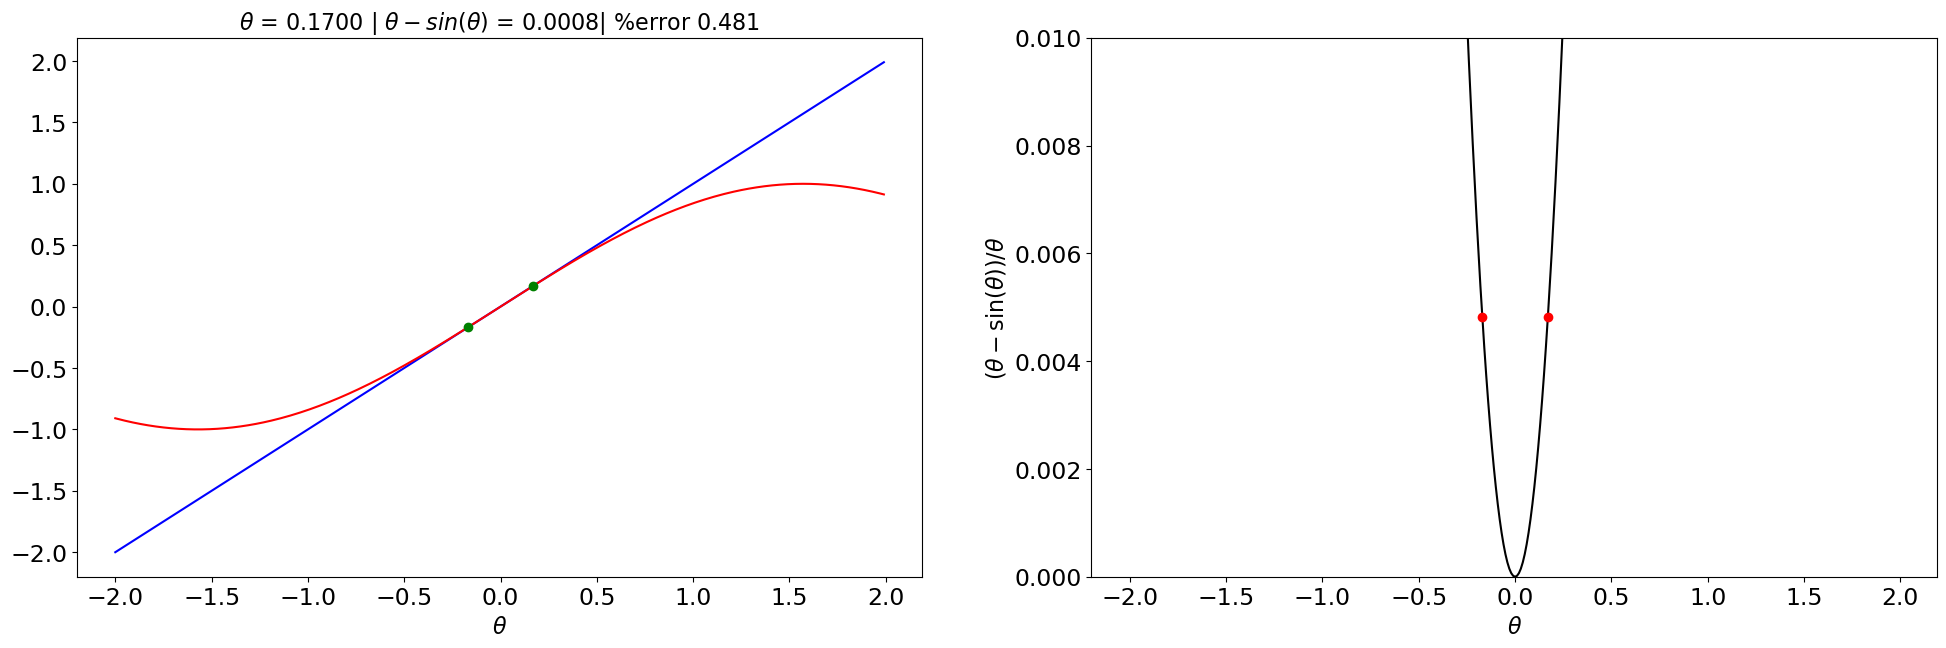

In [17]:
# Use the cell below to examine when we can make the small angle approximation

theta = np.arange(-2,2,0.01)   # use these angles, in radians

fig, ax = plt.subplots(1, 2, figsize = (24, 7))

label = 'theta'
ax[0].plot(theta, theta, color='blue', label = r"$\theta$")
ax[0].plot(theta, np.sin(theta), color='red', label=r"$\sin(theta)$")
ax[0].set_xlabel(r"$\theta$")

diff = theta - np.sin(theta)
ax[1].plot(theta, diff/theta, color='black')
ax[1].set_ylabel(r"$(\theta-\sin(\theta))/\theta$")
ax[1].set_xlabel(r"$\theta$")
ax[1].set_ylim([0, 0.01])

# compute the largest positive value of theta for which theta=sin(theta) to better that 0.5 per cent.
# use the values of theta generated above
# plot the range  on the graph below

Pdiff = diff / theta
good = ((theta > 0) & (Pdiff < 0.005))
title = r"$\theta$ = {0:1.4f} | $\theta - sin(\theta)$ = {1:1.4f}| %error {2:1.3f}" \
        .format(theta[good][-1], diff[good][-1], Pdiff[good][-1]*100)

ax[0].set(title=title)
ax[0].plot(theta[good][-1], theta[good][-1], marker= 'o', color = 'green')
ax[0].plot(-theta[good][-1], -theta[good][-1], marker= 'o', color = 'green')
ax[1].plot(theta[good][-1], Pdiff[good][-1], marker= 'o', color = 'red')
ax[1].plot(-theta[good][-1], Pdiff[good][-1], marker= 'o', color = 'red')

plt.show()

### Pendulum

In the cell below, we will create a class `Pendulum`. It will contain methods for the (original) Euler, for the Runge-Kutta method, and for the Euler-Cromer timestepping method. We will implement `dx_dt(self,x,t)` for the first two, and `dx_dt_EC(self,x,t)` for the EC-solver. Within a the class, you have access to


    self.x        - the state vector
    self.t        - the time
    self.delta_t  - the time step
    
    self.L        - pendulum's length
    self.g        - gravity acceleration
    self.FD       - driving acceleration, F_d/m
    self.OD       - driving frequency
    self.q        - friction coefficient
    self.nonlin   - boolean that determines whether pendulum is linear (nonlin=false: small-angle approximation) or non-linear (nonlin=true)
    
The coordinates of the pendulum are the angle measured from the vertical ($\theta$ in the notes), and its time derivative ($\dot\theta={\rm d}\theta/{\rm d}t$). In the implementation below, $\theta$ and $\dot\theta$ are the first and second entry of the state vector $x$:

` x=np.array([theta, dtheta/dt]) `


**Energy $E$ of pendulum:**

$$
E = \frac{1}{2}ml^{2}\omega^{2} + mgl(1 - cos\theta) \approx \frac{1}{2}ml^{2}\omega^{2} + \frac{1}{2}mgl\theta^{2}
$$

in the small angle approximation

**Damping of pendulum:**

Damping is due to friction or air resistance that could slow down the pendulum bob:
$$
\ddot{\theta} = -\Omega^{2} \theta - q \dot{\theta}
$$
where $q > 0$

Analytical solution depends on value of $q$

1. Under-damped regime ($q < 2 \Omega$) -> amplitude decays exponentially
$$
\theta(t) = \theta_{0} \exp \left( -\frac{qt}{2} \right) sin \left(\sqrt{\Omega^{2}-q^{2}/4} \cdot t + \phi \right)
$$

2. Over-damped regime ($q > 2 \Omega$) -> no oscillations occurs
$$
\theta(t) = \theta_{0} \exp \left[- \left( \frac{q}{2} + \sqrt{q^{2}/4 - \Omega^{2}} \right) \cdot t \right]
$$

3. Critically damped regime ($q = 2\Omega$) -> Pendulum returns to equilibrium at once
$$
\theta(t) = (\theta_{0}+Ct) \exp \left( - \frac{qt}{2} \right)
$$


**Driven oscillation:**

Add a driving force to the pendulum and the equation becomes:

$$
\ddot{\theta} = - \Omega^{2} \theta - q \dot{\theta} + F_{d} sin (\Omega_{D} t)
$$

Analytical solution:

$$
\theta(t) = \theta_{max} sin(\Omega_{D}t + \phi) \\
\theta_{max} = \frac{F_{D}}{\sqrt{(\Omega^{2} - \Omega_{D}^{2})^{2} + (q \Omega_{D})^{2}}}
$$

**Resonance** occurs when $\Omega_{D} \rightarrow \Omega$

**Implement with Euler's method:**

**Spoiler:** The Euler's method will not work on pendulum because the *Amplitude* increases with time even for small $\Delta t$

$$
\theta^{n+1} = \theta^{n} + \omega^{n} \Delta t \\
\omega^{n+1} = \omega^{n} - \frac{g}{l} \theta^{n} \Delta t \\
t^{n+1} = t^{n} + \Delta t
$$

where $\frac{d^{2}\theta}{dt^{2}} = - \frac{g}{l} \theta$ and $\frac{d\theta}{dt} = \omega$

In [44]:
# physical constants used below, g is average gravitational acceleration on Earth's surface
phys_const = {'g':9.81}  # units [m/s^2]

In [45]:
class Pendulum:
    def __init__(self, L, q=0, F_D=0, Omega_D=0, nonlinear=False):
        """Initialize a pendulum object with 
        length L [m], 
        friction coefficient q [1/s], 
        driving acceleration amplitude F_D [N/kg],
        frequency Omega_D [s^-1]. 
        and a boolean switch to enable the nonlinear pendulum"""
        self.L      = float(L)
        self.q      = float(q)
        self.FD     = float(F_D)
        self.OD     = float(Omega_D)
        self.nonlin = nonlinear
        self.g      = phys_const["g"]             # gravitational acceleration on the Earth's surface [m/s^2]

    def dx_dt(self,x,t):
        # calculate the time derivative for 
        #      - the position, x[0]=theta
        #      - the angular velocity, x[1]=dtheta/dt
        # Note that angles are assumed to be in *radians*
        # Include gravity, friction and driving
        # Implement both linear (small-angle) and non-linear (no small-angle approximation) cases
        # Input:   x     = [theta, dtheta/dt], position and velocity of the pendulum at time t
        #       note: input x should be in the form of a numpy array
        # Returns: dx/dt = [dtheta/dt, d^2theta/dt^2]: speed and acceleration of the pendulum
        #      note: function should return dx/dt as an numpy array
        theta, dtheta_dt = x
        if self.nonlin:
            d2theta_dt = -self.g / self.L * np.sin(theta) - self.q * dtheta_dt + self.FD * np.sin(self.OD*t)
        else:
            d2theta_dt = -self.g / self.L * theta - self.q * dtheta_dt + self.FD * np.sin(self.OD*t)
            
        return np.array([dtheta_dt, d2theta_dt])
        
        
       
    def analytic(self,theta0,t):
        return theta0 * np.cos(np.sqrt(self.g/self.L) * t)

    def T(self,x):
        # Compute the kinetic energy per unit mass of the pendulum
        #     note that with have assumed that this mass of the pendulum = 1
        # input:   x     = [theta, dtheta/dt], position and velocity of the pendulum at time t
        # returns: kinetic energy / mass of pendulum
        #
        theta, dtheta_dt = x
        return 1 / 2 * self.L **2 * dtheta_dt**2
        
    def U(self,x):
        # Compute the potential energy per unit mass of the pendulum
        #     note that with have assumed that this mass of the pendulum = 1
        # Note: the expression for U for the linear and non-linear cases are not the same.
        # input:   x     = [theta, dtheta/dt], position and velocity of the pendulum at time t
        # returns: potential energy / mass of pendulum
        #
        theta, dtheta_dt = x
        U     = 0.0
        if self.nonlin:
            # Compute U for the non-linear case
            U = self.g* self.L * (1 - np.cos(theta))
        else:
            # Compute U for the linear (small angle) case
            U = 1 / 2 * self.g* self.L * theta**2
        return U

In [46]:
# this tests the dx_dt implementation
testPend=Pendulum(2.3,1.1,0.5,2.2,False)
testPendNL=Pendulum(2.3,1.1,0.5,2.2,True)
assert np.isclose(testPendNL.dx_dt([0.5,0.3],0.7),[ 0.3, -1.87509123]).all()
assert np.isclose(testPend.dx_dt([0.5,0.3],0.7),[ 0.3, -1.96284578]).all()

In [47]:
#this tests the energy implementation
assert np.isclose(testPend.U([0.5,0.3]),2.820375)
assert np.isclose(testPend.T([0.5,0.3]),0.23805)
assert np.isclose(testPendNL.U([0.5,0.3]),2.7621)
assert np.isclose(testPendNL.T([0.5,0.3]),0.23805)